In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch
from collections import Counter

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the dataset path in Google Drive
data_dir = '/content/drive/My Drive/augmented'





Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch
from collections import Counter


import zipfile
import os

# Path to the uploaded zip file
zip_file_path = '/content/drive/My Drive/Augmented.zip'

# Directory to extract the files
extract_dir = '/content/augmented'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Confirm the extraction and list the directories
extracted_folders = os.listdir(extract_dir)
extracted_folders


['Augmented']

Loaded data summary:
Classes found: Counter({1: 3366, 2: 2496, 0: 720})
Class Distribution (Before Balancing): Counter({1: 3366, 2: 2496, 0: 720})
Class Distribution (After Balancing): Counter({2: 3366, 0: 3366, 1: 720})


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.697796,0.740000
2,No log,0.498709,0.805000
3,No log,0.342704,0.875000


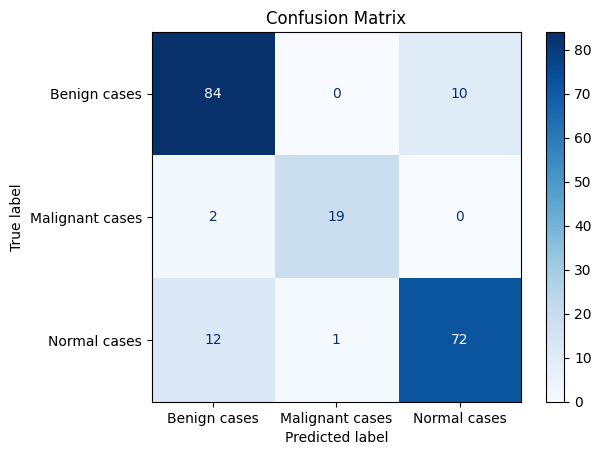

Classification Report:
                 precision    recall  f1-score   support

   Benign cases       0.86      0.89      0.88        94
Malignant cases       0.95      0.90      0.93        21
   Normal cases       0.88      0.85      0.86        85

       accuracy                           0.88       200
      macro avg       0.90      0.88      0.89       200
   weighted avg       0.88      0.88      0.88       200



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value
from PIL import Image
from collections import Counter
import torch

# Step 1: Load Dataset from Augmented Folder
def load_augmented_data(base_dir):
    actual_folders = os.listdir(base_dir)
    classes = ['Bengin cases', 'Malignant cases', 'Normal cases']  # Adjusted to match your folder names
    image_paths = []
    labels = []

    for label, class_name in enumerate(classes):
        if class_name not in actual_folders:
            print(f"Warning: Directory not found: {os.path.join(base_dir, class_name)}")
            continue

        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(label)

    print("Loaded data summary:")
    print(f"Classes found: {Counter(labels)}")
    return image_paths, labels

# Define the base directory
base_dir = '/content/augmented/Augmented'
image_paths, labels = load_augmented_data(base_dir)

# Step 2: Balance the Dataset
class_counts = Counter(labels)
print("Class Distribution (Before Balancing):", class_counts)

data = list(zip(image_paths, labels))
majority_class = max(class_counts, key=class_counts.get)
balanced_data = []

# Oversample minority classes and undersample the majority class
for cls in class_counts:
    class_data = [item for item in data if item[1] == cls]
    if cls == majority_class:
        balanced_data.extend(resample(class_data, replace=False, n_samples=min(class_counts.values())))  # Undersample majority class
    else:
        balanced_data.extend(resample(class_data, replace=True, n_samples=max(class_counts.values())))  # Oversample minority classes

np.random.shuffle(balanced_data)
image_paths, labels = zip(*balanced_data)
print("Class Distribution (After Balancing):", Counter(labels))

# Step 3: Convert to Hugging Face DatasetDict
features = Features({
    "image_path": Value("string"),
    "label": ClassLabel(num_classes=3, names=['Benign cases', 'Malignant cases', 'Normal cases'])
})

dataset = Dataset.from_dict({'image_path': image_paths, 'label': labels}, features=features)
train_test_split = dataset.train_test_split(test_size=0.2, stratify_by_column='label')
datasets = DatasetDict({'train': train_test_split['train'], 'test': train_test_split['test']})

# Step 4: Preprocess Images for Vision Transformer
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Reduce dataset size for faster processing (optional)
datasets['train'] = datasets['train'].select(range(min(len(datasets['train']), 500)))
datasets['test'] = datasets['test'].select(range(min(len(datasets['test']), 200)))

def preprocess_images(example):
    images = [Image.open(path).convert("RGB") for path in example['image_path']]
    inputs = feature_extractor(images=images, return_tensors="pt")
    inputs['label'] = torch.tensor(example['label'])
    return inputs

datasets = datasets.map(preprocess_images, batched=True)

# Step 5: Define the Vision Transformer Model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=3,
    id2label={0: 'Benign cases', 1: 'Malignant cases', 2: 'Normal cases'},
    label2id={'Benign cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
)

# Step 6: Define Training Arguments and Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Reduced batch size for faster execution
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Reduced epochs for faster results
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['test'],
    compute_metrics=compute_metrics
)

# Step 7: Train the Model
trainer.train()

# Step 8: Evaluate the Model
predictions = trainer.predict(datasets['test'])
preds = np.argmax(predictions.predictions, axis=-1)

# Confusion Matrix
cm = confusion_matrix(predictions.label_ids, preds)
labels = ['Benign cases', 'Malignant cases', 'Normal cases']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(predictions.label_ids, preds, target_names=labels))